<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis of Greek proverbs

* Based on a collection of proverbs from the 
  [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) 
  of the Academy of Athens.

* We use [Folium](https://pypi.org/project/folium/) for visualization 
  and [Geopy](https://geopy.readthedocs.io/en/stable/) for geolocation,
  adjusting manually for errors.

In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import os

## Data loading

In [2]:
proverbs = pd.read_csv('data/proverbs.csv', index_col=0)
proverbs.shape

(134493, 4)

In [3]:
proverbs.sample(10)

,text,place,uri,collector
67276,"Όστρια, τρυγονόμερα!","Κέρκυρα, Ερείκουσα",http://hdl.handle.net/20.500.11853/213211,"Λουκάτος, Δημήτριος Σ."
49602,Μ' αυτό το πλευρό να κοιμάσαι!,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/212429,"Κορύλλος, Χρήστος Π."
38812,Η πολλή αγάπη φέρνει κι' αμάχη,"Αρκαδία, Γορτυνία",http://hdl.handle.net/20.500.11853/147314,"Κανδηλώρος, Τάκης Χ."
109930,Κατά το Μαστρο Γιάνν' και τα κοπέλλια τ',Ανατολική Θράκη,http://hdl.handle.net/20.500.11853/210258,"Σταμούλη – Σαραντή, Ελπινίκη"
12239,Είπεν ο χ... τον κλανιά. Κάλλιος εγώ που σένα,Ρόδος,http://hdl.handle.net/20.500.11853/228239,"Δρακίδης, Γεράσιμος Δ."
7608,Ή μκρός μκρός παντρέψ' ή μκρός καλουγιρέψ',Ήπειρος,http://hdl.handle.net/20.500.11853/256068,"Γαλδέμης, Αναστάσιος Δ."
127324,"Αν περάση ο μύρμηγκας από τα γένεια μου, θα πε...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/248839,anonymous
30708,Αράγε γινώσκεις α αναγινώσκεις;,Επτάνησος,http://hdl.handle.net/20.500.11853/174798,"Καββαδίας, Γεώργιος"
53271,Το καλό τ' αρνί δυο μάννες βζάν',"Μικρά Ασία, Κύζικος, Μηχανιώνα",http://hdl.handle.net/20.500.11853/150347,"Κούζος, Γεώργιος Ι."
130061,"Αλί σ' εκείνη την κοιλιά, π' έχει κακόν αφέντη",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/216448,anonymous


In [4]:
# removing noisy input (e.g., definitions)
proverbs[proverbs.text.str.contains("=")].sample().text.item()

'Τω βαλε στα τέσσερα = Prendre ses jambes a soncon'

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Duplicates exist.

* Exact duplicates may be due to error.

* But there are also duplicated texts, meaning proverbs collected in different places.

In [6]:
# exact duplicates
print(proverbs.duplicated().sum())
proverbs[proverbs.duplicated()].sample()

13875


,text,place,uri,collector
131185,Αν δεν γέν'ς ρουσφάει δεν τρώς προσφάει,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/243477,anonymous


In [7]:
# text duplicates
print(proverbs.text.duplicated().sum())
proverbs[proverbs.text.duplicated()].sample(10)

24836


,text,place,uri,collector
133826,Άξια μοίρα σου να δας κοιλιά κλυμμένη και καλο...,"Μικρά Ασία, Κύζικος",http://hdl.handle.net/20.500.11853/206393,anonymous
121500,"1) Το φίδι του Κερονιάτη, 2) Φίδια με κέρατα (...",Ρόδος,http://hdl.handle.net/20.500.11853/297903,anonymous
122223,Αν έπεσαν τα δαχτυλίδια έμειναν τα δάχτυλα,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/166134,anonymous
3937,Σ' σα κοντά τα σκοινιά εν,Πόντος,http://hdl.handle.net/20.500.11853/263922,"Βαλαβάνης, Ι."
71381,"Το στσυλλί πήε σο παθινί, πνώνει νε ατσείνος τ...","Καππαδοκία, Φάρασα",http://hdl.handle.net/20.500.11853/187063,"Λουκόπουλος, Δημήτριος"
124862,Άρρητα ρήματα και νερά κοπανισμένα,Ήπειρος,http://hdl.handle.net/20.500.11853/160195,anonymous
55463,Τα παθήματα γίνονται μαθήματα,Κρήτη,http://hdl.handle.net/20.500.11853/227272,"Κριάρης, Αριστείδης Ι."
125115,Αλλού τα κακαρίσματα κι αλλού γιννούν οι κότις,Θεσσαλία,http://hdl.handle.net/20.500.11853/160327,anonymous
90307,Ζώα μικρά μετά μεγάλων,Κρήτη,http://hdl.handle.net/20.500.11853/164306,"Ξανθουδίδης, Στέφανος Α."
128058,"Αλησμονώ και χαίρομαι, θυμώμαι και ραΐζω",Κόρινθος,http://hdl.handle.net/20.500.11853/241429,anonymous


* Places follow the pattern `area, locus, locus, ...`; where each `locus` is a more precisely located place.

* Having a comma inside the pattern can confuse output (for humans)  in pandas when sets are output as strings.

* So we'll substitute `,` by `>`.

In [8]:
proverbs.place = proverbs.place.str.replace('\s*,\s*', '>', regex=True)
proverbs.place

0             Κρήτη>Λασίθι>Κεντρί
1             Κρήτη>Λασίθι>Κεντρί
2             Κρήτη>Λασίθι>Κεντρί
3             Κρήτη>Λασίθι>Κεντρί
4         Κρήτη>Λασίθι>Τουρτούλοι
                   ...           
134488             Θράκη>Σαμακόβι
134489          Μεσσηνία>Φιλιατρά
134490                     Σίφνος
134491                    Ήπειρος
134492               Ηλεία>Πύργος
Name: place, Length: 134106, dtype: object

* Climbing up to the highest-level information per location labelled.

* In `'Κρήτη>Λασίθι>Κεντρί'`, for example, we only keep the first part of the term, using `split` to tokenise.

In [9]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(">")[0])
proverbs.sample(10)

,text,place,uri,collector,area
88086,Σείσε σείσε το κατσίκι έβαψε το κέρατο κι έβγα...,Ανάφη,http://hdl.handle.net/20.500.11853/252279,"Νεστορίδης, Κ.",Ανάφη
95386,Λύκος εποταμίεν,Πόντος>Χαλδία,http://hdl.handle.net/20.500.11853/217054,"Παπαδόπουλος, Άνθιμος Α.",Πόντος
86715,Όλοι τους με τα τρόχαλα κι αυτός με τα λιθάρια,Λακωνία,http://hdl.handle.net/20.500.11853/289074,"Νεστορίδης, Κ.",Λακωνία
125780,Άναψε το λυχναρι σου πριν σ' εύρη η νύχτα,Κρήτη>Χανιά,http://hdl.handle.net/20.500.11853/246271,anonymous,Κρήτη
61533,Ήρθε της Αγίας Άννης κάτσε ήλιε μου να ξανασάνης,Αρκαδία>Γορτυνία>Λάστα,http://hdl.handle.net/20.500.11853/151042,"Λάσκαρης, Ν.",Αρκαδία
102851,Με τ' άδικα παν και τα δίκαια,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/202875,"Ποταγός, Ν. Ν.",Άδηλου τόπου
88097,Σήκωσε την ουρά του γαιδάρου και φτύσ' τον στο...,Λακωνία,http://hdl.handle.net/20.500.11853/154329,"Νεστορίδης, Κ.",Λακωνία
102824,Και κόρκορος εν λαχάνοις και Σαούλ εν προφήταις,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/267015,"Ποταγός, Ν. Ν.",Άδηλου τόπου
47735,Έκοψε το αίμα του!,Αχαΐα>Πάτρα,http://hdl.handle.net/20.500.11853/149163,"Κορύλλος, Χρήστος Π.",Αχαΐα
15538,"Η πείνα τσι ευγενικοί, αδιάντροποι τσι κάνει",Νάξος>Απείρανθος,http://hdl.handle.net/20.500.11853/263530,"Ζευγώλη – Γλέζου, Διαλεχτή",Νάξος


* One more observation regards proverbs with no information about their location 


In [10]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

In [11]:
locations = proverbs.area.unique()
len(locations)

134

* There are 134 unique broad areas registered in the collection. We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a
  Python client for geocoding web services, we can locate the coordinates (e.g.,
  of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [ ]:
if not os.path.exists('data/geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα", timeout=None) 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
            print(loc, location.latitude, location.longitude)
        else:
            print('Missing:', loc)

    # fixing some by hand; the missing ones plus any errors
    need_fixing = {
        "Phthiotis": ["Φθιώτιδα"],
        "West Mani": ["Δυτική Μάνη"],
        "Cappadocia": ["Καππαδοκία"],
        "Dardanelles": ["Δαρδανέλλια (Ελλήσποντος)"],
        "Phocis": ["Φωκίδα"],
        "Boeotia": ["Βοιωτία"],
        "Areopoli": ["Αερόπολη"],
        "Trifylia": ["Τριφυλία"],
        "Oxya Kastoria": ["Μπλάτση"],
        "Siteia": ["Ανατολική Κρήτη"],
        "Edirne": ["Ανατολική Θράκη"],
        "Andritsaina": ["Ανδρίτσαινα Ολυμπίου"],
        "Chania": ["Δυτική Κρήτη"],
        "Central Greece": ["Στερεά Ελλάδα"],
        "Nafpaktia": ["Ναυπακτία"],
        "Rhodes Regional Unit": ["Δωδεκάνησα"],
        "Aetolia-Acarnania": "Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)",
        "Izmir": ["Μικρά Ασία"], # not in Greece, so error
        "Black Sea Region": ["Πόντος"], # not in Greece, so error
        "Rhodope": ["Θράκη"], # error
        "Cyprus": ["Κύπρος"], # not in Greece, so error
        "Epirus": ["Ήπειρος"] # shown in Kypseli (Athens), so error
    }
    
    for loc, alts in need_fixing.items():
        location = geolocator.geocode(loc)
        for alt in alts:
            print(f'fixing {alt} using {loc}')
            geolocs[alt] = {
                "lat" : location.latitude,
                "lon" : location.longitude
            }

    pd.DataFrame(geolocs).to_csv("data/geolocs.csv", index=False)

Κρήτη 35.308495199999996 24.46334231842296
Σίφνος 36.9714014 24.708110417765855
Σέρρες 41.0910711 23.5498031
Πήλιο 39.3650875 23.1355607
Ήπειρος 37.9982534 23.7378671
Λευκάδα 38.706573399999996 20.64167791041791
Αχαΐα 38.0692748 21.87273042232539
Εύβοια 38.49417235 23.91108439913793
Μακεδονία 40.6186482 22.91795361795959
Κύπρος 35.5131379 24.0196923
Πέλλα 40.7604079 22.5271118
Λέσβος 39.17584185 25.998913450232415
Missing: Άδηλου τόπου
Θράκη 38.0105134 23.7327576
Ρούμελη 37.8845303 23.7476065
Κοζάνη 40.3007259 21.7883119
Σάμος 37.72461615 26.819291891109838
Αρκαδία 37.42908855 22.423541964571157
Missing: Φθιώτιδα
Ίμβρος 35.2541539 24.1704124
Σκύρος 38.87304355 24.524477385184014
Αθήνα 37.9755648 23.7348324
Θάσος 40.6844479 24.651206350038855
Σαμοθράκη 40.4511544 25.585657246305097
Λακωνία 36.76027945 22.79046431389755
Μάνη 36.59942325 22.4243022489021
Λήμνος 39.9088688 25.149960790913052
Νάξος 37.06001045 25.47075670857837
Κέρκυρα 39.591337 19.859618918733858
Πελοπόννησος 37.36332825 2

In [13]:
geolocs = pd.read_csv("data/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,κ,ρ,ί,ς,(,χ,Β,ά,υ,)
lat,35.308495,36.971401,41.091071,39.365088,39.650192,38.706573,38.069275,38.494172,40.618648,34.917416,...,38.703338,38.703338,38.703338,38.703338,38.703338,38.703338,38.703338,38.703338,38.703338,38.703338
lon,24.463342,24.708110,23.549803,23.135561,20.690846,20.641678,21.872730,23.911084,22.917954,32.889903,...,21.249006,21.249006,21.249006,21.249006,21.249006,21.249006,21.249006,21.249006,21.249006,21.249006


* Now we update the corpus with the mined information.

In [14]:
geolocs = geolocs.to_dict()
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(123631, 7)

## The anonymous collector
* Not all proverbs were collected by named individuals.

In [15]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


## Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [ ]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of '
      f'{num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [17]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 104 `area`s.

In [18]:
unique_areas = named[named.text.duplicated()].area.unique()
print(unique_areas)
unique_areas.shape[0]

['Εύβοια' 'Λέσβος' 'Ήπειρος' 'Ρούμελη' 'Κοζάνη' 'Αρκαδία' 'Ίμβρος'
 'Φιλιππούπολη' 'Αττική' 'Πόντος' 'Δαρδανέλλια (Ελλήσποντος)' 'Θράκη'
 'Μακεδονία' 'Κεφαλληνία' 'Μήλος' 'Χίος' 'Μικρά Ασία' 'Κρήτη' 'Κίμωλος'
 'Άνδρος' 'Λέρος' 'Ρόδος' 'Κύπρος' 'Άρτα' 'Πρέβεζα' 'Παξοί' 'Καρδίτσα'
 'Άδηλου τόπου' 'Καστελλόριζο (Μεγίστη)' 'Αθήνα' 'Μεσσηνία' 'Λακωνία'
 'Σίφνος' 'Ηλεία' 'Σύμη' 'Θήρα (Σαντορίνη)' 'Κως' 'Σμύρνη' 'Κάλυμνος'
 'Νάξος' 'Αδριανούπολη' 'Ευρυτανία' 'Κέρκυρα' 'Αμοργός' 'Θεσπρωτία'
 'Σάμος' 'Καστοριά' 'Βοιωτία' 'Επτάνησος' 'Νίσυρος' 'Αχαΐα' 'Κορινθία'
 'Τήλος' 'Πέλλα' 'Λάρισα' 'Κύθηρα' 'Ιωάννινα' 'Ημαθία' 'Φωκίδα'
 'Πελοπόννησος' 'Σύρος' 'Μάνη' 'Σκύρος' 'Αιτωλία' 'Κύθνος' 'Τήνος' 'Κέα'
 'Άγιον Όρος' 'Πάρος' 'Θεσσαλία' 'Μάλγαρα' 'Ανατολική Κρήτη' 'Μαγνησία'
 'Σέριφος' 'Ιθάκη' 'Λευκάδα' 'Αργολίδα' 'Καππαδοκία' 'Ακαρνανία'
 'Ζάκυνθος' 'Ικαρία' 'Φθιώτιδα' 'Τρίκαλα' 'Κάρπαθος' 'Λήμνος' 'Μπλάτση'
 'Κάσος' 'Αιτωλοακαρνανία' 'Ανάφη' 'Κόρινθος' 'Στερεά Ελλάδα' 'Θάσος'
 'Αστυπάλαια' 'Βόρειος Ήπ

104

* We group by `text` the `named` duplicates , to get duplicates using items by named collectors.

In [19]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.agg(set)})
duplicates["place_num"] = duplicates.place.agg(len)
duplicates.sort_values(by="place_num", ascending=False)[:10]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη>Κυδωνία, Κοζάνη>Βόϊο>Ανθούσα, Κρήτη>Βιά...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Αχαΐα>Πάτρα, Μακεδονία>Γρεβενά>Ανασελίτσα, Θρ...",27
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Φωκίδα>Δελφοί, Ιωάννινα>Χουλιαράδες, Αρκαδία>...",26
Θεωρία επισκόπου και καρδιά μυλωνά,"{Αχαΐα>Πάτρα, Λακωνία, Θράκη>Αίνος, Δαρδανέλλι...",26
"Θέρος, τρύγος, πόλεμος","{Αχαΐα>Καλάβρυτα>Σουδενά, Αχαΐα>Πάτρα, Κορινθί...",22
Των φρονίμων τα παιδιά πριν πεινασουν μαγειρεύουν,"{Νίσυρος>Μανδράκι, Αχαΐα>Πάτρα, Κορινθία>Τρίκα...",20
Το γουδί το γουδοχέρι,"{Πήλιο>Ζαγορά, Ήπειρος>Κόνιτσα>Βούρμπιανη, Μακ...",18
Καλομελέτα κι έρχεται,"{Μικρά Ασία>Κυδωνία, Μεσσηνία>Αετός Τριφυλίας,...",17
Το γοργόν και χάριν έχει,"{Πήλιο>Ζαγορά, Δαρδανέλλια (Ελλήσποντος), Κρήτ...",17


* As previously, we'll get the broader location, which we'll call `area`.

In [ ]:
duplicates["area"] = duplicates.place.map(
    lambda x: {i.split(">")[0] for i in x})
duplicates["area_num"] = duplicates.area.agg(len)
duplicates.sort_values(by="area_num", ascending=False)[:10]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη>Κυδωνία, Κοζάνη>Βόϊο>Ανθούσα, Κρήτη>Βιά...",45,"{Μικρά Ασία, Θεσπρωτία, Αχαΐα, Ημαθία, Θράκη, ...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Φωκίδα>Δελφοί, Ιωάννινα>Χουλιαράδες, Αρκαδία>...",26,"{Θεσπρωτία, Λακωνία, Θράκη, Ικαρία, Κοζάνη, Νί...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Αχαΐα>Πάτρα, Μακεδονία>Γρεβενά>Ανασελίτσα, Θρ...",27,"{Δαρδανέλλια (Ελλήσποντος), Θράκη, Μακεδονία, ...",17
Των φρονίμων τα παιδιά πριν πεινασουν μαγειρεύουν,"{Νίσυρος>Μανδράκι, Αχαΐα>Πάτρα, Κορινθία>Τρίκα...",20,"{Θράκη, Μακεδονία, Θήρα (Σαντορίνη), Κορινθία,...",16
Θεωρία επισκόπου και καρδιά μυλωνά,"{Αχαΐα>Πάτρα, Λακωνία, Θράκη>Αίνος, Δαρδανέλλι...",26,"{Θράκη, Δαρδανέλλια (Ελλήσποντος), Μακεδονία, ...",16
Το γοργόν και χάριν έχει,"{Πήλιο>Ζαγορά, Δαρδανέλλια (Ελλήσποντος), Κρήτ...",17,"{Θράκη, Δαρδανέλλια (Ελλήσποντος), Ρούμελη, Εύ...",16
"Θέρος, τρύγος, πόλεμος","{Αχαΐα>Καλάβρυτα>Σουδενά, Αχαΐα>Πάτρα, Κορινθί...",22,"{Θράκη, Σκύρος, Μακεδονία, Αργολίδα, Κορινθία,...",16
Καλομελέτα κι έρχεται,"{Μικρά Ασία>Κυδωνία, Μεσσηνία>Αετός Τριφυλίας,...",17,"{Θράκη, Μακεδονία, Ρούμελη, Κοζάνη, Μικρά Ασία...",15
Το γουδί το γουδοχέρι,"{Πήλιο>Ζαγορά, Ήπειρος>Κόνιτσα>Βούρμπιανη, Μακ...",18,"{Θράκη, Μακεδονία, Θήρα (Σαντορίνη), Εύβοια, Ά...",15


In [21]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 104583 unique texts, 3128 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [22]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [ ]:
coordinates = duplicates.area.map(
    lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
        for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample(10)

,place,place_num,area,area_num,latlon
text,,,,,
Μοναχός σου χόρευε κι όσο θέλεις πήδαε,"{Μικρά Ασία>Βιθυνία>Τσινάρι, Μικρά Ασία>Βιθυνί...",4,"{Θράκη, Μικρά Ασία}",2,"[(41.56093875, 24.72805745786389), (38.9597594..."
Τα μυαλά σου και μια λίρα και του μπογιατζή ο κόπανος,"{Κως>Πυλί, Ρούμελη}",2,"{Ρούμελη, Κως}",2,"[(37.8845303, 23.7476065), (36.79369325, 27.08..."
Καθάριος ουρανός αστραπές δε φοβάται,"{Πήλιο>Ζαγορά, Δαρδανέλλια (Ελλήσποντος), Μικρ...",3,"{Δαρδανέλλια (Ελλήσποντος), Πήλιο, Μικρά Ασία}",3,"[(40.20917255, 26.44139082761628), (39.3650875..."
"Μη με πειράζης με το βελόνι, μη σε τρυπήσω με τη σακκοράφα","{Λακωνία, Θεσσαλία}",2,"{Λακωνία, Θεσσαλία}",2,"[(36.76027945, 22.79046431389755), (39.5564697..."
Σήκω σύ να κάτσω 'γώ,"{Φιλιππούπολη, Μικρά Ασία>Βουρλά}",2,"{Φιλιππούπολη, Μικρά Ασία}",2,"[(39.6327644, 22.3965233), (38.9597594, 34.924..."
Ο καιρός πουλεί τα ξύλα κ΄η φουρτούνα τ΄αγοράζει,"{Αμοργός, Θήρα (Σαντορίνη)}",2,"{Αμοργός, Θήρα (Σαντορίνη)}",2,"[(36.85252415, 25.898486967715655), (36.407111..."
Τα λέει ουρθά κουφτά,"{Ιωάννινα>Νεγάδες, Ήπειρος>Ζαγόρι}",2,"{Ήπειρος, Ιωάννινα}",2,"[(39.6501917, 20.690845557013784), (39.6639818..."
Της αδικιάς τα λάχανα τζουκάλι δεν τα βράζει,"{Λακωνία, Μεσσηνία}",2,"{Λακωνία, Μεσσηνία}",2,"[(36.76027945, 22.79046431389755), (36.7069481..."
Αμαρτίες γονέων παιδεύουσι τέκνα,"{Κύπρος, Θεσπρωτία>Κωστάνα, Ιωάννινα>Μέγα Περι...",3,"{Θεσπρωτία, Κύπρος, Ιωάννινα}",3,"[(39.54401235, 20.308355368968883), (34.917415..."


In [24]:
# saving
duplicates.to_csv("data/duplicates_geolocated.csv")

* To visualise the dataframe, we use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note: outliers exist, e.g., Chiesa della Madona delle Neve

In [25]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html")
m

* Finding the number of areas sharing proverbs with crowded Athens.

In [26]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 19


## Single-placed proverbs

In [27]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


,text,place,uri,collector,area,lat,lon
3659,Ντο επετράγωσες και τρανείς με,Πόντος,http://hdl.handle.net/20.500.11853/141179,"Βαλαβάνης, Ι.",Πόντος,41.066580,38.105787
50129,Ο αναμάρτητος πρώτος βαλέτω τον λίθον,Αχαΐα>Πάτρα,http://hdl.handle.net/20.500.11853/149353,"Κορύλλος, Χρήστος Π.",Αχαΐα,38.069275,21.872730
19936,Το γκαβό κομμάτια δώσ' του,Μακεδονία>Σισάνι>Λιμπόχοβο,http://hdl.handle.net/20.500.11853/172423,"Ιωαννίδης, Αθ.",Μακεδονία,40.618648,22.917954


* We'll move aside single-placed proberbs from an unknown place.

In [28]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
54074,Τον τρελλόν κ' τον χωριάτην ξένες έννοιες τον ...,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/204667,"Κουμανούδης, Π.",Άδηλου τόπου,NaN,NaN
88627,Τη μυίγα κάνει βόϊδι και τον ποντικό Γιανίτζαρο,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/270293,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
41470,Με έναν λόγον κραβαρίτικα πράγματα,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/237903,"Κασομούλης, Νικόλαος Κ.",Άδηλου τόπου,NaN,NaN


* We'll work with the rest.

In [29]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


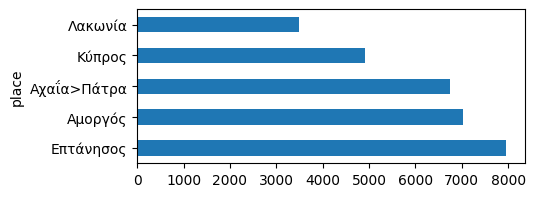

In [30]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(5,2));

* Visualising the places along with the number of proverbs collected in each.

In [31]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(">")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html')
m

* Next, we'll work with places which have 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [32]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


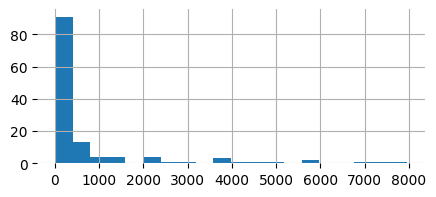

In [33]:
placed_pd.length.hist(bins=20, figsize=(5,2));
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [34]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* Removing proverbs with unknown (invalid?) characters.

In [35]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus.

In [36]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TFILF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across locations (location > document) are more important (ILF). 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=1, lowercase=True)
X = vect.fit_transform(long_texts)

In [39]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [40]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζ,0.0,0.011732,0.0,0.0,0.0,0.0,0.0,0.015007,0.0,0.017863,...,0.0,0.638483,0.0,0.0,0.0,0.0,0.014089,0.0,0.0,0.00000
τζαι,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.387047,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000
τζαί,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.310922,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01266


* Computing a lexicon with the terms with the highest TFIDF value per area

In [41]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
area_ngrams

{'Ήπειρος': ['τουν', 'ου', 'είνε'],
 'Αιτωλία': ['τουν', 'ου', 'είνι'],
 'Αμοργός': ['μηδέ', 'κακόν', 'λωλός'],
 'Ανατολική Θράκη': ['νε', 'καμήλα', 'άπλωναν'],
 'Αρκαδία': ['ήρθε', 'άγιε', 'δίνεις'],
 'Αχαΐα': ['τογ', 'τομ', 'ειπούμε'],
 'Επτάνησος': ['ναν', 'τσου', 'θαν'],
 'Εύβοια': ['τσαί', 'τσαι', 'λιά'],
 'Θεσπρωτία': ['κόλο', 'είτε', 'γιά'],
 'Θράκη': ['πε', 'τς', 'δι'],
 'Ιωάννινα': ['ου', 'τουν', 'τουγ'],
 'Κάρπαθος': ['τσαι', 'εσού', 'τσαί'],
 'Κεφαλληνία': ['τσου', 'τση', 'οπού'],
 'Κρήτη': ['ντου', 'τση', 'οντέ'],
 'Κύπρος': ['τζ', 'τζαι', 'τζαί'],
 'Λέσβος': ['τσι', 'τουν', 'είνι'],
 'Λακωνία': ['πουτάνας', 'συμπεθέρα', 'κάνεις'],
 'Μακεδονία': ['ου', 'τουν', 'άλλαξεν'],
 'Μικρά Ασία': ['τουν', 'κη', 'είνιν'],
 'Νάξος': ['ια', 'τζη', 'εώ'],
 'Πόντος': ['ατ', 'σο', 'άτο'],
 'Ρόδος': ['κάμνει', 'λωλλός', 'λωλλό'],
 'Σκύρος': ['τσαί', 'τσαι', 'έναι']}

* Locating the important terms per location on a map (clickable pins)

In [ ]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(
        folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html')
m

In [43]:
geotfidf.to_csv("data/geotfidf.csv", index=False)
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,τουν,τουν,μηδέ,νε,ήρθε,τογ,ναν,τσαί,κόλο,πε,...,ντου,τζ,τσι,πουτάνας,ου,τουν,ια,ατ,κάμνει,τσαί
1,ου,ου,κακόν,καμήλα,άγιε,τομ,τσου,τσαι,είτε,τς,...,τση,τζαι,τουν,συμπεθέρα,τουν,κη,τζη,σο,λωλλός,τσαι
2,είνε,είνι,λωλός,άπλωναν,δίνεις,ειπούμε,θαν,λιά,γιά,δι,...,οντέ,τζαί,είνι,κάνεις,άλλαξεν,είνιν,εώ,άτο,λωλλό,έναι


In [44]:
# using English names and printing a latex table
loc_name = {'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Macedonia', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
for area in area_ngrams:
    print(f'{loc_name[area]} & {" & ".join(area_ngrams[area])} \\\\')

Epirus & τουν & ου & είνε \\
Etolia & τουν & ου & είνι \\
Amorgos & μηδέ & κακόν & λωλός \\
East Thrace & νε & καμήλα & άπλωναν \\
Arcadia & ήρθε & άγιε & δίνεις \\
Achaia & τογ & τομ & ειπούμε \\
Eptanisos & ναν & τσου & θαν \\
Eyvoia & τσαί & τσαι & λιά \\
Thesprotia & κόλο & είτε & γιά \\
Thrace & πε & τς & δι \\
Ioannina & ου & τουν & τουγ \\
Karpathos & τσαι & εσού & τσαί \\
Kefalinia & τσου & τση & οπού \\
Crete & ντου & τση & οντέ \\
Cyprus & τζ & τζαι & τζαί \\
Lesvos & τσι & τουν & είνι \\
Laconia & πουτάνας & συμπεθέρα & κάνεις \\
Macedonia & ου & τουν & άλλαξεν \\
Asia Minor & τουν & κη & είνιν \\
Naxos & ια & τζη & εώ \\
Pontos & ατ & σο & άτο \\
Rodos & κάμνει & λωλλός & λωλλό \\
Skyros & τσαί & τσαι & έναι \\


In [45]:
balanced_corpus.to_csv('balanced_corpus.csv', index=False)